# Hierarchical Multi-Agent Reinforcement Learning for Congestion-Aware Vessel Scheduling

**Supervised by Prof. Amine Aboussalah, Abdessalam Ed-dib and Idriss Malek**  

This Colab notebook is an MVP (minimum viable prototype) that sketches a working pipeline for hierarchical MARL with congestion forecasting and port coordination. The goal is to be **descriptive**, **traceable**, and **executable** with simplified components so we can iterate quickly before scaling to a full simulator and MAPPO training.

## Table of contents
1. Project framing, objectives, and research questions
2. Architecture and data flow
3. Configuration
4. Simulator (MVP environment)
   - 4.1 State definitions and initialization
   - 4.2 Environment dynamics (vessel movement, port operations, emissions)
   - 4.3 Gymnasium environment skeleton
5. Forecasting module (mock)
6. Agent decision stubs (hierarchical control)
   - 6.1 Centralized critic stub (CTDE)
7. Reward functions
8. Metrics and evaluation hooks
   - 8.1 Forecasting, agent, coordination, and economic metrics
9. Experiment protocol and baselines
   - 9.1 Ablation runner framework
10. MVP execution and visualization
    - 10.1 Rollout with full pipeline
    - 10.2 Baseline comparison (forecast vs reactive vs independent)
11. MVP-to-Research checklist
12. Next steps for the full project


## 1. Project framing, objectives, and research questions
We model a maritime network with **heterogeneous agents**:
- **Fleet coordinator** (strategic decisions, 12–24h cadence)
- **Vessel agents** (operational speed/arrival control, 1–4h cadence)
- **Port agents** (dock allocation and service scheduling, 2–6h cadence)

**MVP objectives**:
- Validate the **information flow** between forecasting, coordinator, vessel, and port layers.
- Provide a **minimal environment** with vessel movement, port queuing, and emission tracking.
- Establish **reward functions** and **metric hooks** that map directly to the full study.
- Demonstrate baseline comparisons (independent → reactive → forecast-informed → oracle).

We simulate a small system (1 coordinator, 8 vessels, 5 ports) and use a toy environment to demonstrate the **data flow** and **learning loops**.

### Research questions traced in this MVP
| RQ | Question | Where tested |
|----|----------|--------------|
| **RQ1** | How can heterogeneous agents coordinate using shared congestion forecasts to minimize system-wide costs? | §6 policies, §10 rollout |
| **RQ2** | Does proactive coordination with forecasts improve over (a) independent and (b) reactive policies? | §10.2 baseline comparison |
| **RQ3** | How should forecasts be distributed among agents, and which horizons help most? | §9.1 ablation runner |
| **RQ4** | How do coordination improvements affect economic outcomes (price, reliability)? | §8.1 economic metrics |


## 2. Architecture and data flow
```
Fleet Coordinator  → (Strategic Directives) →  Vessel Agents  → (Arrival Requests) →  Port Agents
Port Agents        → (Dock Availability)   →  Vessel Agents
```
**Forecasting usage**:
- Medium-term forecasts (3–7 days) inform the **fleet coordinator**.
- Short-term forecasts (6–24 hours) inform **vessels and ports**.

This MVP will keep policies simple but will expose the exact data each agent sees.

### 2.1 MDP summary (MVP view)
We keep the MDP definition lightweight here and focus on the observation/action channels that will later map to Gymnasium spaces.

### 2.2 Observation and action schema (MVP interface)
To keep the prototype coherent across modules, we define a consistent interface for each agent. This will later map directly to Gymnasium spaces.

**Fleet coordinator**
- **Obs**: [port congestion forecast (P × Hm), vessel summaries (V × k), cumulative emissions]
- **Act**: [destination port (categorical P), departure window (hours), emission budget] 

**Vessel agent**
- **Obs**: [current port, speed, fuel, short-term forecast for destination (Hs), coordinator directive, dock availability] 
- **Act**: [speed setting (continuous), requested arrival time] 

**Port agent**
- **Obs**: [queue length, dock occupancy, expected arrivals, vessel requests] 
- **Act**: [dock assignment, service priority order] 

This schema is intentionally compact so we can test wiring before scaling state complexity.


### 2.3 Centralized critic view (CTDE placeholder)
During training, a centralized critic can consume the concatenated global state: [all agent observations + joint actions + global congestion stats].
This notebook keeps it as a placeholder to ensure MAPPO compatibility later.


In [2]:
mdp_summary = pd.DataFrame(
    [
        {
            "agent": "Fleet Coordinator",
            "observations": "Medium-term forecasts, vessel states, emissions",
            "actions": "Destination port, departure window, emission budget",
            "reward": "- (voyage cost + emission penalty)",
        },
        {
            "agent": "Vessel",
            "observations": "Short-term forecasts, position/speed, directives",
            "actions": "Speed adjustment, arrival request",
            "reward": "- (fuel + delay + emissions)",
        },
        {
            "agent": "Port",
            "observations": "Queue, dock occupancy, arrival requests",
            "actions": "Dock allocation, service rate",
            "reward": "- (queue wait + dock idle)",
        },
    ]
)
mdp_summary

,agent,observations,actions,reward
0,Fleet Coordinator,"Medium-term forecasts, vessel states, emissions","Destination port, departure window, emission b...",- (voyage cost + emission penalty)
1,Vessel,"Short-term forecasts, position/speed, directives","Speed adjustment, arrival request",- (fuel + delay + emissions)
2,Port,"Queue, dock occupancy, arrival requests","Dock allocation, service rate",- (queue wait + dock idle)


## 3. Configuration
We keep dependencies minimal for the MVP. In a full implementation, this section will include MARL frameworks (e.g., RLlib, MARLlib) and forecasting libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
from abc import ABC, abstractmethod

SEED = 42


### 3.1 Core experiment parameters
We centralize key parameters so the team can adjust horizons, weights, and counts in one place.

In [3]:
CONFIG = {
    # --- Fleet topology ---
    "num_ports": 5,
    "num_vessels": 8,
    "docks_per_port": 3,

    # --- Forecast horizons ---
    "medium_horizon_days": 5,
    "short_horizon_hours": 12,

    # --- Reward weights (α, β, γ in the proposal) ---
    "fuel_weight": 1.0,       # α
    "delay_weight": 1.5,      # β
    "emission_weight": 0.7,   # γ
    "emission_lambda": 2.0,   # λ  (coordinator emission penalty)
    "dock_idle_weight": 0.5,  # port idle-dock penalty

    # --- Physics (simplified) ---
    "fuel_rate_coeff": 0.002,        # fuel consumption: k * speed^3 (tons/hour)
    "emission_factor": 3.114,        # tons CO2 per ton of fuel (IMO default)
    "speed_min": 8.0,                # knots
    "speed_max": 18.0,               # knots
    "nominal_speed": 12.0,           # knots

    # --- Economic parameters (RQ4) ---
    "cargo_value_per_vessel": 1_000_000,  # USD (notional)
    "fuel_price_per_ton": 600,            # USD
    "delay_penalty_per_hour": 5_000,      # USD
    "carbon_price_per_ton": 90,           # USD (EU ETS ballpark)

    # --- Simulation ---
    "rollout_steps": 20,
    "seed": SEED,
}

# Distance matrix (nautical miles) between 5 ports — symmetric
# Ports: 0=Singapore, 1=Rotterdam, 2=Shanghai, 3=Dubai, 4=Los Angeles (notional)
DISTANCE_NM = np.array([
    [   0,  8400,  2200,  3400, 7800],
    [8400,     0,  9800,  6100, 5400],
    [2200,  9800,     0,  5500, 5900],
    [3400,  6100,  5500,     0, 8200],
    [7800,  5400,  5900,  8200,    0],
], dtype=float)

CONFIG


{'num_ports': 5,
 'num_vessels': 8,
 'docks_per_port': 3,
 'medium_horizon_days': 5,
 'short_horizon_hours': 12,
 'fuel_weight': 1.0,
 'delay_weight': 1.5,
 'emission_weight': 0.7,
 'emission_lambda': 2.0,
 'dock_idle_weight': 0.5,
 'fuel_rate_coeff': 0.002,
 'emission_factor': 3.114,
 'speed_min': 8.0,
 'speed_max': 18.0,
 'nominal_speed': 12.0,
 'cargo_value_per_vessel': 1000000,
 'fuel_price_per_ton': 600,
 'delay_penalty_per_hour': 5000,
 'carbon_price_per_ton': 90,
 'rollout_steps': 20,
 'seed': 42}

## 4. Simulator (MVP environment)
We implement a **discrete-event toy simulator** that captures the key physical signals: vessel transit between ports, fuel consumption, CO₂ emissions, queue lengths, and dock occupancy. This is intentionally small and interpretable so we can debug coordination and forecast usage early.

### 4.1 State definitions and initialization


In [4]:
@dataclass
class PortState:
    """State of a single port."""
    port_id: int
    queue: int                          # vessels waiting for a dock
    docks: int                          # total dock capacity
    occupied: int                       # docks currently in use
    cumulative_wait_hours: float = 0.0  # total waiting time accumulated
    vessels_served: int = 0             # count of vessels served

@dataclass
class VesselState:
    """State of a single vessel."""
    vessel_id: int
    location: int              # current port index (-1 = at sea)
    destination: int           # target port index
    position_nm: float = 0.0   # nautical miles traveled on current leg
    speed: float = 12.0        # current speed in knots
    fuel: float = 100.0        # remaining fuel (tons)
    emissions: float = 0.0     # cumulative CO2 (tons)
    delay_hours: float = 0.0   # accumulated delay vs scheduled arrival
    at_sea: bool = False       # True when transiting between ports

# ---------------------------------------------------------------------------
# Initialization helpers
# ---------------------------------------------------------------------------

def make_rng(seed: int = SEED) -> np.random.Generator:
    """Create a fresh RNG — avoids shared-state bugs across experiments."""
    return np.random.default_rng(seed)

def initialize_ports(num_ports: int, docks_per_port: int = 3,
                     rng: np.random.Generator = None) -> List[PortState]:
    rng = rng or make_rng()
    return [
        PortState(
            port_id=i,
            queue=int(rng.integers(0, 5)),
            docks=docks_per_port,
            occupied=int(rng.integers(0, docks_per_port)),
        )
        for i in range(num_ports)
    ]

def initialize_vessels(num_vessels: int, num_ports: int,
                       rng: np.random.Generator = None) -> List[VesselState]:
    rng = rng or make_rng()
    return [
        VesselState(
            vessel_id=i,
            location=int(rng.integers(0, num_ports)),
            destination=int(rng.integers(0, num_ports)),
            speed=CONFIG["nominal_speed"],
            fuel=100.0,
        )
        for i in range(num_vessels)
    ]

# Quick sanity check
rng = make_rng()
NUM_PORTS = CONFIG["num_ports"]
NUM_VESSELS = CONFIG["num_vessels"]
ports = initialize_ports(NUM_PORTS, CONFIG["docks_per_port"], rng)
vessels = initialize_vessels(NUM_VESSELS, NUM_PORTS, rng)
print("Ports :", ports[:2])
print("Vessels:", vessels[:2])


Ports : [PortState(port_id=0, queue=0, docks=3, occupied=2, cumulative_wait_hours=0.0, vessels_served=0), PortState(port_id=1, queue=3, docks=3, occupied=1, cumulative_wait_hours=0.0, vessels_served=0)]
Vessels: [VesselState(vessel_id=0, location=2, destination=4, position_nm=0.0, speed=12.0, fuel=100.0, emissions=0.0, delay_hours=0.0, at_sea=False), VesselState(vessel_id=1, location=3, destination=3, position_nm=0.0, speed=12.0, fuel=100.0, emissions=0.0, delay_hours=0.0, at_sea=False)]


### 4.2 Environment dynamics (vessel movement, port operations, emissions)
We define **three step functions** that evolve the system each tick:
1. `step_vessels()` — moves vessels along their route, burns fuel, accumulates emissions.
2. `step_ports()` — serves queued vessels, updates dock occupancy.
3. `compute_fuel_and_emissions()` — physics helper: fuel ∝ speed³, CO₂ ∝ fuel × emission factor.


In [5]:
# ---------------------------------------------------------------------------
# Physics helpers
# ---------------------------------------------------------------------------

def compute_fuel_and_emissions(speed: float, hours: float = 1.0) -> Tuple[float, float]:
    """
    Simplified cubic fuel model (standard in maritime literature).
    Returns (fuel_consumed_tons, co2_tons) for the given duration.
    """
    k = CONFIG["fuel_rate_coeff"]
    fuel = k * (speed ** 3) * hours          # tons of fuel
    co2  = fuel * CONFIG["emission_factor"]  # tons of CO2
    return fuel, co2

# ---------------------------------------------------------------------------
# Vessel step
# ---------------------------------------------------------------------------

def step_vessels(vessels: List[VesselState], dt_hours: float = 1.0) -> None:
    """Advance every vessel by dt_hours. Vessels at sea move toward destination."""
    for v in vessels:
        if not v.at_sea:
            continue  # vessel is docked or idle at port
        # Distance traveled this tick
        nm_traveled = v.speed * dt_hours
        v.position_nm += nm_traveled
        # Fuel & emissions
        fuel_used, co2 = compute_fuel_and_emissions(v.speed, dt_hours)
        v.fuel = max(v.fuel - fuel_used, 0.0)
        v.emissions += co2
        # Check arrival
        leg_distance = DISTANCE_NM[v.location, v.destination]
        if v.position_nm >= leg_distance:
            v.position_nm = 0.0
            v.location = v.destination
            v.at_sea = False

# ---------------------------------------------------------------------------
# Port step
# ---------------------------------------------------------------------------

def step_ports(ports: List[PortState], service_rates: List[int],
               dt_hours: float = 1.0) -> None:
    """Serve queued vessels at each port."""
    for port, rate in zip(ports, service_rates):
        served = min(port.queue, rate)
        port.queue = max(port.queue - served, 0)
        port.occupied = min(port.docks, port.occupied + served)
        port.vessels_served += served
        # Remaining queue vessels accumulate wait time
        port.cumulative_wait_hours += port.queue * dt_hours

# ---------------------------------------------------------------------------
# Dispatch: send a vessel from its current port to a destination
# ---------------------------------------------------------------------------

def dispatch_vessel(vessel: VesselState, destination: int, speed: float) -> None:
    """Set a vessel to depart for a new destination at a given speed."""
    speed = np.clip(speed, CONFIG["speed_min"], CONFIG["speed_max"])
    vessel.destination = destination
    vessel.speed = speed
    vessel.position_nm = 0.0
    vessel.at_sea = True

# ---------------------------------------------------------------------------
# Quick observation helper (reused by metrics and policies)
# ---------------------------------------------------------------------------

def observe_port_metrics(ports: List[PortState]) -> Dict[str, float]:
    avg_queue = float(np.mean([p.queue for p in ports]))
    dock_util = float(np.mean([p.occupied / p.docks for p in ports]))
    total_wait = float(sum(p.cumulative_wait_hours for p in ports))
    return {"avg_queue": avg_queue, "dock_utilization": dock_util, "total_wait_hours": total_wait}

# Test physics
fuel_1h, co2_1h = compute_fuel_and_emissions(speed=12.0, hours=1.0)
print(f"At 12 kn for 1 h → fuel={fuel_1h:.3f} t, CO₂={co2_1h:.3f} t")
fuel_1h_fast, co2_1h_fast = compute_fuel_and_emissions(speed=18.0, hours=1.0)
print(f"At 18 kn for 1 h → fuel={fuel_1h_fast:.3f} t, CO₂={co2_1h_fast:.3f} t  (×{co2_1h_fast/co2_1h:.1f})")


At 12 kn for 1 h → fuel=3.456 t, CO₂=10.762 t
At 18 kn for 1 h → fuel=11.664 t, CO₂=36.322 t  (×3.4)


### 4.3 Gymnasium environment skeleton
We define a `MaritimeEnv` class that follows the Gymnasium API (`reset()`, `step()`).
This skeleton wires together the vessel movement, port operations, forecasting, and agent interfaces so that MAPPO can be plugged in later with minimal refactoring.

> **Note**: We do not install Gymnasium as a dependency in the MVP — the class inherits from a simple ABC instead. Swapping to `gymnasium.Env` later requires only changing the base class and adding `observation_space` / `action_space` as proper Gymnasium `Space` objects.


In [9]:
class MaritimeEnv:
    """
    Gymnasium-style multi-agent maritime environment (MVP skeleton).

    Agents
    ------
    - 1 Fleet Coordinator  (strategic, every `coord_freq` steps)
    - V Vessel agents      (operational, every step)
    - P Port agents        (operational, every step)

    Observation / action shapes are intentionally kept as dicts of numpy
    arrays so the transition to gymnasium.spaces.Dict is straightforward.
    """

    def __init__(self, config: dict = CONFIG, seed: int = SEED):
        self.cfg = config
        self.rng = make_rng(seed)
        self.num_ports = config["num_ports"]
        self.num_vessels = config["num_vessels"]
        self.t = 0

        # Will be populated by reset()
        self.ports: List[PortState] = []
        self.vessels: List[VesselState] = []

        # --- Observation / action space descriptors (for MAPPO wiring) ---
        # These describe the *shape* of each agent's obs and action vectors.
        self.obs_shapes = {
            "coordinator": (self.num_ports * config["medium_horizon_days"]   # forecasts
                            + self.num_vessels * 4                           # vessel summaries
                            + 1),                                           # cumulative emissions
            "vessel": (1 + 1 + 1 + 1                                       # location, speed, fuel, emissions
                       + config["short_horizon_hours"]                      # forecast for dest port
                       + 3),                                                # directive (dest, window, budget)
            "port": (1 + 1 + 1                                             # queue, docks, occupied
                     + config["short_horizon_hours"]                        # forecast
                     + 1),                                                  # incoming requests
        }
        self.action_shapes = {
            "coordinator": self.num_ports + 2,   # dest logits + window + budget
            "vessel": 2,                          # speed, arrival_request
            "port": 2,                            # service_rate, accept_flag
        }

    # ----- reset -----
    def reset(self) -> Dict[str, np.ndarray]:
        """Reset all state and return initial observations."""
        self.t = 0
        self.rng = make_rng(self.cfg["seed"])
        self.ports = initialize_ports(self.num_ports, self.cfg["docks_per_port"], self.rng)
        self.vessels = initialize_vessels(self.num_vessels, self.num_ports, self.rng)
        return self._get_observations()

    # ----- step -----
    def step(self, actions: Dict[str, list]) -> Tuple[Dict, Dict, bool, Dict]:
        """
        Execute one environment tick.

        Parameters
        ----------
        actions : dict
            "coordinator" : dict from fleet_coordinator_policy
            "vessels"     : list of dicts from vessel_policy
            "ports"       : list of dicts from port_policy

        Returns
        -------
        obs, rewards, done, info
        """
        coord_action = actions["coordinator"]
        vessel_actions = actions["vessels"]
        port_actions = actions["ports"]

        # 1. Dispatch idle vessels according to coordinator directive
        for v, va in zip(self.vessels, vessel_actions):
            if not v.at_sea:
                dispatch_vessel(v, coord_action["dest_port"], va["target_speed"])

        # 2. Move vessels
        step_vessels(self.vessels, dt_hours=1.0)

        # 3. Arriving vessels join the port queue
        for v in self.vessels:
            if not v.at_sea and v.location == v.destination:
                port = self.ports[v.location]
                port.queue += 1

        # 4. Ports serve vessels
        service_rates = [pa["service_rate"] for pa in port_actions]
        step_ports(self.ports, service_rates)

        # 5. Compute rewards
        rewards = self._compute_rewards(coord_action, vessel_actions, port_actions)

        self.t += 1
        done = self.t >= self.cfg["rollout_steps"]
        obs = self._get_observations()
        info = {"port_metrics": observe_port_metrics(self.ports)}
        return obs, rewards, done, info

    # ----- observations -----
    def _get_observations(self) -> Dict[str, np.ndarray]:
        """Build observation vectors for every agent."""
        medium = medium_term_forecast(self.num_ports, self.cfg["medium_horizon_days"])
        short  = short_term_forecast(self.num_ports, self.cfg["short_horizon_hours"])

        # Coordinator obs: flattened medium forecast + vessel summaries + total emissions
        vessel_summaries = np.array([
            [v.location, v.speed, v.fuel, v.emissions] for v in self.vessels
        ])
        total_emissions = sum(v.emissions for v in self.vessels)
        coord_obs = np.concatenate([
            medium.flatten(),
            vessel_summaries.flatten(),
            [total_emissions],
        ])

        # Vessel obs (one per vessel)
        vessel_obs = []
        for v in self.vessels:
            dest_forecast = short[v.destination] if v.destination < self.num_ports else short[0]
            v_obs = np.concatenate([
                [v.location, v.speed, v.fuel, v.emissions],
                dest_forecast,
                [0, 0, 0],  # placeholder for directive — filled by policy wrapper
            ])
            vessel_obs.append(v_obs)

        # Port obs (one per port)
        port_obs = []
        for i, p in enumerate(self.ports):
            p_obs = np.concatenate([
                [p.queue, p.docks, p.occupied],
                short[i],
                [0],  # incoming requests — filled by policy wrapper
            ])
            port_obs.append(p_obs)

        return {
            "coordinator": coord_obs,
            "vessels": vessel_obs,
            "ports": port_obs,
        }

    # ----- rewards (placeholder, see §7 for full definitions) -----
    def _compute_rewards(self, coord_action, vessel_actions, port_actions) -> Dict:
        """Compute per-agent rewards. Detailed formulas in §7."""
        vessel_rewards = [
            compute_vessel_reward(v) for v in self.vessels
        ]
        port_rewards = [
            compute_port_reward(p) for p in self.ports
        ]
        coord_reward = compute_coordinator_reward(self.vessels, self.ports)
        return {
            "coordinator": coord_reward,
            "vessels": vessel_rewards,
            "ports": port_rewards,
        }

    # ----- centralized critic state (CTDE, §2.3) -----
    def get_global_state(self) -> np.ndarray:
        """
        Concatenate all agent observations + global stats into a single
        vector for the centralized critic during MAPPO training.
        """
        obs = self._get_observations()
        global_congestion = np.array([p.queue for p in self.ports], dtype=float)
        total_emissions = np.array([sum(v.emissions for v in self.vessels)])
        return np.concatenate([
            obs["coordinator"],
            *obs["vessels"],
            *obs["ports"],
            global_congestion,
            total_emissions,
        ])

# Instantiate and test reset
env = MaritimeEnv()
obs = env.reset()
print("Coordinator obs shape:", obs["coordinator"].shape)
print("Vessel 0 obs shape:   ", obs["vessels"][0].shape)
print("Port 0 obs shape:     ", obs["ports"][0].shape)
print("Global state shape:   ", env.get_global_state().shape)


Coordinator obs shape: (58,)
Vessel 0 obs shape:    (19,)
Port 0 obs shape:      (16,)
Global state shape:    (296,)


## 5. Forecasting module (mock)
The **medium-term forecaster** provides a 3–7 day congestion estimate for each port. The **short-term forecaster** outputs 6–24 hour predictions. Here we mock them with noisy trends to validate the data flow.

### 5.1 Forecast ablation hooks
We will test the value of forecasting via controlled ablations:
- **Horizon sweep**: short (6h), medium (12h), long (24h)
- **Accuracy sweep**: add calibrated noise to forecasts
- **Oracle vs learned**: perfect vs model-predicted congestion
- **Sharing**: coordinator-only vs shared with vessels/ports


In [6]:
def medium_term_forecast(num_ports: int, horizon_days: int = 5) -> np.ndarray:
    base = rng.uniform(2, 8, size=(num_ports, 1))
    trend = np.linspace(0, 1.5, horizon_days)[None, :]
    noise = rng.normal(0, 0.3, size=(num_ports, horizon_days))
    return np.clip(base + trend + noise, 0, None)

def short_term_forecast(num_ports: int, horizon_hours: int = 12) -> np.ndarray:
    base = rng.uniform(1, 6, size=(num_ports, 1))
    noise = rng.normal(0, 0.5, size=(num_ports, horizon_hours))
    return np.clip(base + noise, 0, None)

medium_forecast = medium_term_forecast(NUM_PORTS, horizon_days=CONFIG["medium_horizon_days"])
short_forecast = short_term_forecast(NUM_PORTS, horizon_hours=CONFIG["short_horizon_hours"])
medium_forecast.shape, short_forecast.shape

((5, 5), (5, 12))

## 6. Agent decision stubs (hierarchical control)
We create placeholder policies that **consume forecasts** and **emit actions**. These are not learned yet; they simply show the flow of information and will be replaced with MAPPO policies later.

In [7]:
def fleet_coordinator_policy(medium_forecast: np.ndarray,
                            vessels: List[VesselState]) -> Dict:
    """
    Strategic policy: pick the least-congested port and set an emission budget.
    Consumes medium-term forecast (RQ1, RQ3).
    """
    port_scores = medium_forecast.mean(axis=1)
    dest_port = int(np.argmin(port_scores))
    total_emissions = sum(v.emissions for v in vessels)
    return {
        "dest_port": dest_port,
        "departure_window_hours": 12,
        "emission_budget": max(50.0 - total_emissions * 0.1, 10.0),
    }

def vessel_policy(vessel: VesselState, short_forecast: np.ndarray,
                  directive: Dict) -> Dict:
    """
    Operational policy: adjust speed based on congestion forecast (RQ1).
    Reduces speed when destination port is congested to save fuel/emissions.
    """
    dest_port = directive["dest_port"]
    congestion = float(short_forecast[dest_port].mean())
    # Slow down if congestion is high (slow-steaming to wait out the queue)
    if congestion > 5.0:
        speed = CONFIG["speed_min"]
    elif congestion > 3.0:
        speed = CONFIG["nominal_speed"]
    else:
        speed = CONFIG["speed_max"]
    return {
        "target_speed": speed,
        "request_arrival_slot": True,
    }

def port_policy(port_state: PortState, incoming_requests: int,
                short_forecast_row: np.ndarray) -> Dict:
    """
    Port policy: adjust service rate based on predicted pressure (RQ1).
    Opens all docks when near-term congestion is forecast to be high.
    """
    pressure = float(short_forecast_row.mean())
    if pressure > 4.0:
        service_rate = port_state.docks  # full capacity
    elif port_state.queue > 2:
        service_rate = min(port_state.docks, port_state.queue)
    else:
        service_rate = min(port_state.docks, port_state.occupied + 1)
    return {
        "service_rate": service_rate,
        "accept_requests": min(incoming_requests, port_state.docks - port_state.occupied),
    }

# ------ Quick test of the full hierarchy ------
rng = make_rng()
ports = initialize_ports(NUM_PORTS, CONFIG["docks_per_port"], rng)
vessels = initialize_vessels(NUM_VESSELS, NUM_PORTS, rng)
medium_forecast = medium_term_forecast(NUM_PORTS, CONFIG["medium_horizon_days"])
short_forecast  = short_term_forecast(NUM_PORTS, CONFIG["short_horizon_hours"])

directive = fleet_coordinator_policy(medium_forecast, vessels)
v_actions = [vessel_policy(v, short_forecast, directive) for v in vessels]
incoming  = sum(1 for a in v_actions if a["request_arrival_slot"])
p_actions = [port_policy(p, incoming, short_forecast[i]) for i, p in enumerate(ports)]

# Dispatch vessels and step
for v, va in zip(vessels, v_actions):
    dispatch_vessel(v, directive["dest_port"], va["target_speed"])
step_vessels(vessels, dt_hours=1.0)
step_ports(ports, [a["service_rate"] for a in p_actions])

print("Directive:", directive)
print("Vessel 0 action:", v_actions[0])
print("Port 0 action:  ", p_actions[0])
print("Port metrics:   ", observe_port_metrics(ports))
print("Vessel 0 emissions:", f"{vessels[0].emissions:.4f} t CO₂")


Directive: {'dest_port': 4, 'departure_window_hours': 12, 'emission_budget': 50.0}
Vessel 0 action: {'target_speed': 18.0, 'request_arrival_slot': True}
Port 0 action:   {'service_rate': 3, 'accept_requests': 1}
Port metrics:    {'avg_queue': 0.0, 'dock_utilization': 0.7333333333333333, 'total_wait_hours': 0.0}
Vessel 0 emissions: 36.3217 t CO₂


## 7. Reward functions
We implement the three per-agent reward functions from the MDP formulation (§2.1):
- **Coordinator**: $R_C = -(\text{voyage cost} + \lambda \cdot \text{emission penalty})$
- **Vessel**: $R_V = -(\alpha \cdot \text{Fuel}(v) + \beta \cdot \text{Delay} + \gamma \cdot \text{Emissions}(v))$
- **Port**: $R_P = -(\text{Queue wait time} + \text{Dock idle time})$

These are the negative-cost rewards used by PPO/MAPPO during training.


In [8]:
# ---------------------------------------------------------------------------
# Vessel reward: R_V = -(α·Fuel + β·Delay + γ·Emissions)
# ---------------------------------------------------------------------------

def compute_vessel_reward(vessel: VesselState) -> float:
    """Per-step vessel reward (negative cost)."""
    fuel_used, co2 = compute_fuel_and_emissions(vessel.speed, hours=1.0)
    fuel_cost     = CONFIG["fuel_weight"]     * fuel_used
    delay_cost    = CONFIG["delay_weight"]     * vessel.delay_hours
    emission_cost = CONFIG["emission_weight"]  * co2
    return -(fuel_cost + delay_cost + emission_cost)

# ---------------------------------------------------------------------------
# Port reward: R_P = -(queue wait + dock idle)
# ---------------------------------------------------------------------------

def compute_port_reward(port: PortState) -> float:
    """Per-step port reward (negative cost)."""
    queue_penalty = float(port.queue)       # penalize long queues
    idle_docks    = max(port.docks - port.occupied, 0)
    idle_penalty  = CONFIG["dock_idle_weight"] * idle_docks
    return -(queue_penalty + idle_penalty)

# ---------------------------------------------------------------------------
# Coordinator reward: R_C = -(voyage cost + λ·emission penalty)
# ---------------------------------------------------------------------------

def compute_coordinator_reward(vessels: List[VesselState],
                               ports: List[PortState]) -> float:
    """System-level coordinator reward (negative cost)."""
    total_fuel_cost = sum(
        compute_fuel_and_emissions(v.speed, 1.0)[0] for v in vessels
    )
    total_emissions = sum(v.emissions for v in vessels)
    avg_queue = float(np.mean([p.queue for p in ports]))
    emission_penalty = CONFIG["emission_lambda"] * total_emissions
    voyage_cost = total_fuel_cost + avg_queue
    return -(voyage_cost + emission_penalty)

# ------ Test all three rewards ------
print("Vessel 0 reward:", f"{compute_vessel_reward(vessels[0]):.4f}")
print("Port 0 reward:  ", f"{compute_port_reward(ports[0]):.4f}")
print("Coordinator reward:", f"{compute_coordinator_reward(vessels, ports):.4f}")


Vessel 0 reward: -37.0892
Port 0 reward:   -0.5000
Coordinator reward: -674.4591


## 8. Metrics and evaluation hooks
We implement the full set of metrics from the proposal (§6.3), covering forecasting, agent performance, coordination quality, and economic impact (RQ4).

### 8.1 Forecasting, agent, coordination, and economic metrics


In [10]:
# =====================================================================
# FORECASTING METRICS
# =====================================================================

def forecast_mae(predicted: np.ndarray, actual: np.ndarray) -> float:
    """Mean Absolute Error between forecast and realized congestion."""
    return float(np.mean(np.abs(predicted - actual)))

def forecast_rmse(predicted: np.ndarray, actual: np.ndarray) -> float:
    """Root Mean Squared Error between forecast and realized congestion."""
    return float(np.sqrt(np.mean((predicted - actual) ** 2)))

# =====================================================================
# VESSEL METRICS
# =====================================================================

def compute_vessel_metrics(vessels: List[VesselState]) -> Dict[str, float]:
    """Comprehensive vessel-level metrics."""
    avg_speed      = float(np.mean([v.speed for v in vessels]))
    avg_fuel       = float(np.mean([v.fuel for v in vessels]))
    total_fuel_used = float(sum(100.0 - v.fuel for v in vessels))
    total_emissions = float(sum(v.emissions for v in vessels))
    avg_delay      = float(np.mean([v.delay_hours for v in vessels]))
    # On-time rate: fraction of vessels with delay < 2 h (threshold)
    on_time_count  = sum(1 for v in vessels if v.delay_hours < 2.0)
    on_time_rate   = on_time_count / len(vessels) if vessels else 0.0
    return {
        "avg_speed": avg_speed,
        "avg_fuel_remaining": avg_fuel,
        "total_fuel_used": total_fuel_used,
        "total_emissions_co2": total_emissions,
        "avg_delay_hours": avg_delay,
        "on_time_rate": on_time_rate,
    }

# =====================================================================
# PORT METRICS
# =====================================================================

def compute_port_metrics(ports: List[PortState]) -> Dict[str, float]:
    """Comprehensive port-level metrics."""
    avg_queue    = float(np.mean([p.queue for p in ports]))
    dock_util    = float(np.mean([p.occupied / p.docks for p in ports]))
    total_wait   = float(sum(p.cumulative_wait_hours for p in ports))
    total_served = int(sum(p.vessels_served for p in ports))
    avg_wait_per = total_wait / total_served if total_served > 0 else 0.0
    return {
        "avg_queue": avg_queue,
        "dock_utilization": dock_util,
        "total_wait_hours": total_wait,
        "total_vessels_served": total_served,
        "avg_wait_per_vessel": avg_wait_per,
    }

# =====================================================================
# COORDINATION METRICS
# =====================================================================

def compute_coordination_metrics(v_actions: List[Dict],
                                 p_actions: List[Dict]) -> Dict[str, float]:
    """Measure coordination quality between vessels and ports."""
    total_requests = sum(1 for a in v_actions if a["request_arrival_slot"])
    total_accepted = sum(a.get("accept_requests", 0) for a in p_actions)
    agreement_rate = total_accepted / total_requests if total_requests > 0 else 0.0
    return {
        "total_vessel_requests": total_requests,
        "total_port_accepted": total_accepted,
        "policy_agreement_rate": agreement_rate,
    }

# =====================================================================
# ECONOMIC METRICS (RQ4)
# =====================================================================

def compute_economic_metrics(vessels: List[VesselState],
                             ports: List[PortState]) -> Dict[str, float]:
    """
    Estimate economic impact of coordination (RQ4).
    Captures fuel cost, delay penalties, carbon cost, and effective
    shipping price per vessel.
    """
    fuel_cost_total = sum(
        (100.0 - v.fuel) * CONFIG["fuel_price_per_ton"] for v in vessels
    )
    delay_cost_total = sum(
        v.delay_hours * CONFIG["delay_penalty_per_hour"] for v in vessels
    )
    carbon_cost_total = sum(
        v.emissions * CONFIG["carbon_price_per_ton"] for v in vessels
    )
    total_ops_cost = fuel_cost_total + delay_cost_total + carbon_cost_total

    # Effective shipping price = ops cost divided across fleet
    n = len(vessels)
    price_per_vessel = total_ops_cost / n if n > 0 else 0.0

    # Reliability = fraction of cargo value NOT consumed by ops costs
    cargo_total = n * CONFIG["cargo_value_per_vessel"]
    reliability = 1.0 - (total_ops_cost / cargo_total) if cargo_total > 0 else 0.0

    return {
        "fuel_cost_usd": fuel_cost_total,
        "delay_cost_usd": delay_cost_total,
        "carbon_cost_usd": carbon_cost_total,
        "total_ops_cost_usd": total_ops_cost,
        "price_per_vessel_usd": price_per_vessel,
        "cost_reliability": reliability,
    }

# ------ Test all metric groups ------
v_metrics = compute_vessel_metrics(vessels)
p_metrics = compute_port_metrics(ports)
c_metrics = compute_coordination_metrics(v_actions, p_actions)
e_metrics = compute_economic_metrics(vessels, ports)

print("Vessel metrics:      ", v_metrics)
print("Port metrics:        ", p_metrics)
print("Coordination metrics:", c_metrics)
print("Economic metrics:    ", {k: f"{v:,.2f}" for k, v in e_metrics.items()})


Vessel metrics:       {'avg_speed': 18.0, 'avg_fuel_remaining': 88.336, 'total_fuel_used': 93.31200000000001, 'total_emissions_co2': 290.57356799999997, 'avg_delay_hours': 0.0, 'on_time_rate': 1.0}
Port metrics:         {'avg_queue': 0.0, 'dock_utilization': 0.7333333333333333, 'total_wait_hours': 0.0, 'total_vessels_served': 6, 'avg_wait_per_vessel': 0.0}
Coordination metrics: {'total_vessel_requests': 8, 'total_port_accepted': 8, 'policy_agreement_rate': 1.0}
Economic metrics:     {'fuel_cost_usd': '55,987.20', 'delay_cost_usd': '0.00', 'carbon_cost_usd': '26,151.62', 'total_ops_cost_usd': '82,138.82', 'price_per_vessel_usd': '10,267.35', 'cost_reliability': '0.99'}


## 9. Experiment protocol and baselines
Each experiment run follows a consistent protocol:
1. `reset()` — initialize environment, ports, vessels (with a controlled seed).
2. Generate forecasts (or use oracle / zero-noise variants).
3. Execute coordination loop: coordinator → vessels → ports.
4. Log **all** metrics: vessel, port, coordination, economic, rewards.
5. Repeat over N episodes and compare against baselines.

**Baselines** (addressing RQ2):
| Label | Coordination | Forecasts | Description |
|-------|-------------|-----------|-------------|
| **Independent** | None | None | Each agent acts alone, no message passing |
| **Reactive** | Yes | None | Agents coordinate but only use current state |
| **Forecast** | Yes | Learned | Agents use medium + short-term forecasts (proposed) |
| **Oracle** | Yes | Perfect | Agents see true future congestion (upper bound) |

### 9.1 Ablation runner framework
We define a parameterized `run_experiment()` that sweeps over policy types, forecast horizons, and noise levels to support controlled ablation studies (RQ3).


In [11]:
# =====================================================================
# Ablation runner — parameterized experiment loop
# =====================================================================

def run_experiment(
    policy_type: str = "forecast",   # "independent", "reactive", "forecast", "oracle"
    forecast_horizon: int = 12,      # short-term horizon (hours)
    forecast_noise: float = 0.5,     # std of Gaussian noise added to forecasts
    share_forecasts: bool = True,    # whether vessels/ports see forecasts
    steps: int = 20,
    seed: int = SEED,
) -> pd.DataFrame:
    """
    Run one experiment episode and return a per-step log DataFrame.

    Policy types
    ------------
    - independent : no coordination, no forecasts, nominal speed
    - reactive    : coordination via current state only (no forecasts)
    - forecast    : coordination with noisy learned forecasts (proposed)
    - oracle      : coordination with perfect (noise-free) forecasts (upper bound)
    """
    rng_exp = make_rng(seed)
    ports_exp   = initialize_ports(NUM_PORTS, CONFIG["docks_per_port"], rng_exp)
    vessels_exp = initialize_vessels(NUM_VESSELS, NUM_PORTS, rng_exp)
    log = []

    for t in range(steps):
        # --- Generate forecasts ---
        noise_scale = 0.0 if policy_type == "oracle" else forecast_noise
        medium = medium_term_forecast(NUM_PORTS, CONFIG["medium_horizon_days"])
        short  = short_term_forecast(NUM_PORTS, forecast_horizon)
        if noise_scale > 0:
            medium += rng_exp.normal(0, noise_scale, medium.shape)
            short  += rng_exp.normal(0, noise_scale, short.shape)
            medium = np.clip(medium, 0, None)
            short  = np.clip(short, 0, None)

        # --- Coordinator ---
        if policy_type == "independent":
            # Random destination, no coordination
            directive = {
                "dest_port": int(rng_exp.integers(0, NUM_PORTS)),
                "departure_window_hours": 12,
                "emission_budget": 50.0,
            }
        else:
            directive = fleet_coordinator_policy(medium, vessels_exp)

        # --- Vessel policies ---
        if policy_type == "independent":
            v_actions = [{"target_speed": CONFIG["nominal_speed"],
                          "request_arrival_slot": False} for _ in vessels_exp]
        elif policy_type == "reactive":
            v_actions = [{"target_speed": CONFIG["nominal_speed"],
                          "request_arrival_slot": True} for _ in vessels_exp]
        else:
            use_forecast = short if share_forecasts else np.zeros_like(short)
            v_actions = [vessel_policy(v, use_forecast, directive) for v in vessels_exp]

        # --- Dispatch idle vessels ---
        for v, va in zip(vessels_exp, v_actions):
            if not v.at_sea:
                dispatch_vessel(v, directive["dest_port"], va["target_speed"])

        # --- Step physics ---
        step_vessels(vessels_exp, dt_hours=1.0)

        # Arriving vessels join queue
        for v in vessels_exp:
            if not v.at_sea and v.location == v.destination:
                ports_exp[v.location].queue += 1

        # --- Port policies ---
        incoming = sum(1 for a in v_actions if a.get("request_arrival_slot", False))
        if policy_type == "independent":
            p_actions = [{"service_rate": 1, "accept_requests": 0} for _ in ports_exp]
        else:
            use_forecast_port = short if share_forecasts else np.zeros_like(short)
            p_actions = [
                port_policy(p, incoming, use_forecast_port[i])
                for i, p in enumerate(ports_exp)
            ]
        step_ports(ports_exp, [a["service_rate"] for a in p_actions])

        # --- Log metrics ---
        v_m = compute_vessel_metrics(vessels_exp)
        p_m = compute_port_metrics(ports_exp)
        c_m = compute_coordination_metrics(v_actions, p_actions)
        e_m = compute_economic_metrics(vessels_exp, ports_exp)
        rewards_v = [compute_vessel_reward(v) for v in vessels_exp]
        rewards_p = [compute_port_reward(p) for p in ports_exp]
        reward_c  = compute_coordinator_reward(vessels_exp, ports_exp)

        log.append({
            "t": t,
            "policy": policy_type,
            "forecast_horizon": forecast_horizon,
            "forecast_noise": forecast_noise,
            **v_m, **p_m, **c_m, **e_m,
            "avg_vessel_reward": float(np.mean(rewards_v)),
            "avg_port_reward": float(np.mean(rewards_p)),
            "coordinator_reward": reward_c,
        })

    return pd.DataFrame(log)

# ------ Quick validation ------
df_test = run_experiment(policy_type="forecast", steps=5, seed=42)
print("Columns:", list(df_test.columns))
df_test.head()


Columns: ['t', 'policy', 'forecast_horizon', 'forecast_noise', 'avg_speed', 'avg_fuel_remaining', 'total_fuel_used', 'total_emissions_co2', 'avg_delay_hours', 'on_time_rate', 'avg_queue', 'dock_utilization', 'total_wait_hours', 'total_vessels_served', 'avg_wait_per_vessel', 'total_vessel_requests', 'total_port_accepted', 'policy_agreement_rate', 'fuel_cost_usd', 'delay_cost_usd', 'carbon_cost_usd', 'total_ops_cost_usd', 'price_per_vessel_usd', 'cost_reliability', 'avg_vessel_reward', 'avg_port_reward', 'coordinator_reward']


,t,policy,forecast_horizon,forecast_noise,avg_speed,avg_fuel_remaining,total_fuel_used,total_emissions_co2,avg_delay_hours,on_time_rate,...,policy_agreement_rate,fuel_cost_usd,delay_cost_usd,carbon_cost_usd,total_ops_cost_usd,price_per_vessel_usd,cost_reliability,avg_vessel_reward,avg_port_reward,coordinator_reward
0,0,forecast,12,0.5,12.00,96.544,27.648,86.095872,0.0,1.0,...,1.0,16588.8,0.0,7748.62848,24337.42848,3042.17856,0.996958,-10.989389,-0.8,-200.239744
1,1,forecast,12,0.5,14.25,90.010,79.920,248.870880,0.0,1.0,...,0.5,47952.0,0.0,22398.37920,70350.37920,8793.79740,0.991206,-20.776813,-0.4,-550.013760
2,2,forecast,12,0.5,14.25,83.476,132.192,411.645888,0.0,1.0,...,0.5,79315.2,0.0,37048.12992,116363.32992,14545.41624,0.985455,-20.776813,-0.4,-875.563776
3,3,forecast,12,0.5,14.25,76.942,184.464,574.420896,0.0,1.0,...,0.5,110678.4,0.0,51697.88064,162376.28064,20297.03508,0.979703,-20.776813,-0.4,-1201.113792
4,4,forecast,12,0.5,14.25,70.408,236.736,737.195904,0.0,1.0,...,0.5,142041.6,0.0,66347.63136,208389.23136,26048.65392,0.973951,-20.776813,-0.4,-1526.663808


## 10. MVP execution and visualization
We run the ablation runner across all four baseline policies to show the end-to-end pipeline and compare outcomes (RQ2). This is **not** learned training — it uses the policy stubs to validate wiring before integrating MAPPO.

### 10.1 Rollout with full pipeline


In [12]:
# Run all four baseline policies
STEPS = CONFIG["rollout_steps"]

results = {}
for policy in ["independent", "reactive", "forecast", "oracle"]:
    results[policy] = run_experiment(policy_type=policy, steps=STEPS, seed=SEED)

# Combine into one DataFrame for easy comparison
all_results = pd.concat(results.values(), ignore_index=True)

# Show summary: final-step metrics per policy
summary = (
    all_results
    .groupby("policy")
    .agg({
        "avg_queue": "mean",
        "dock_utilization": "mean",
        "total_emissions_co2": "last",
        "total_fuel_used": "last",
        "on_time_rate": "mean",
        "total_ops_cost_usd": "last",
        "cost_reliability": "last",
        "avg_vessel_reward": "mean",
        "coordinator_reward": "mean",
        "policy_agreement_rate": "mean",
    })
    .round(3)
)
summary


,avg_queue,dock_utilization,total_emissions_co2,total_fuel_used,on_time_rate,total_ops_cost_usd,cost_reliability,avg_vessel_reward,coordinator_reward,policy_agreement_rate
policy,,,,,,,,,,
forecast,0.01,0.797,5325.837,777.328,1.0,945722.115,0.882,-33.990,-5701.935,0.412
independent,0.04,0.730,1721.917,552.960,1.0,486748.570,0.939,-10.989,-1835.701,0.000
oracle,0.02,0.733,3178.821,645.600,1.0,673453.892,0.916,-20.287,-3315.978,0.525
reactive,0.02,0.733,1721.917,552.960,1.0,486748.570,0.939,-10.989,-1835.681,0.525


### 10.2 Visualization: comparative plots across all baselines
We compare all four policies across key dimensions to validate that the hierarchy and forecasts have the expected effect.


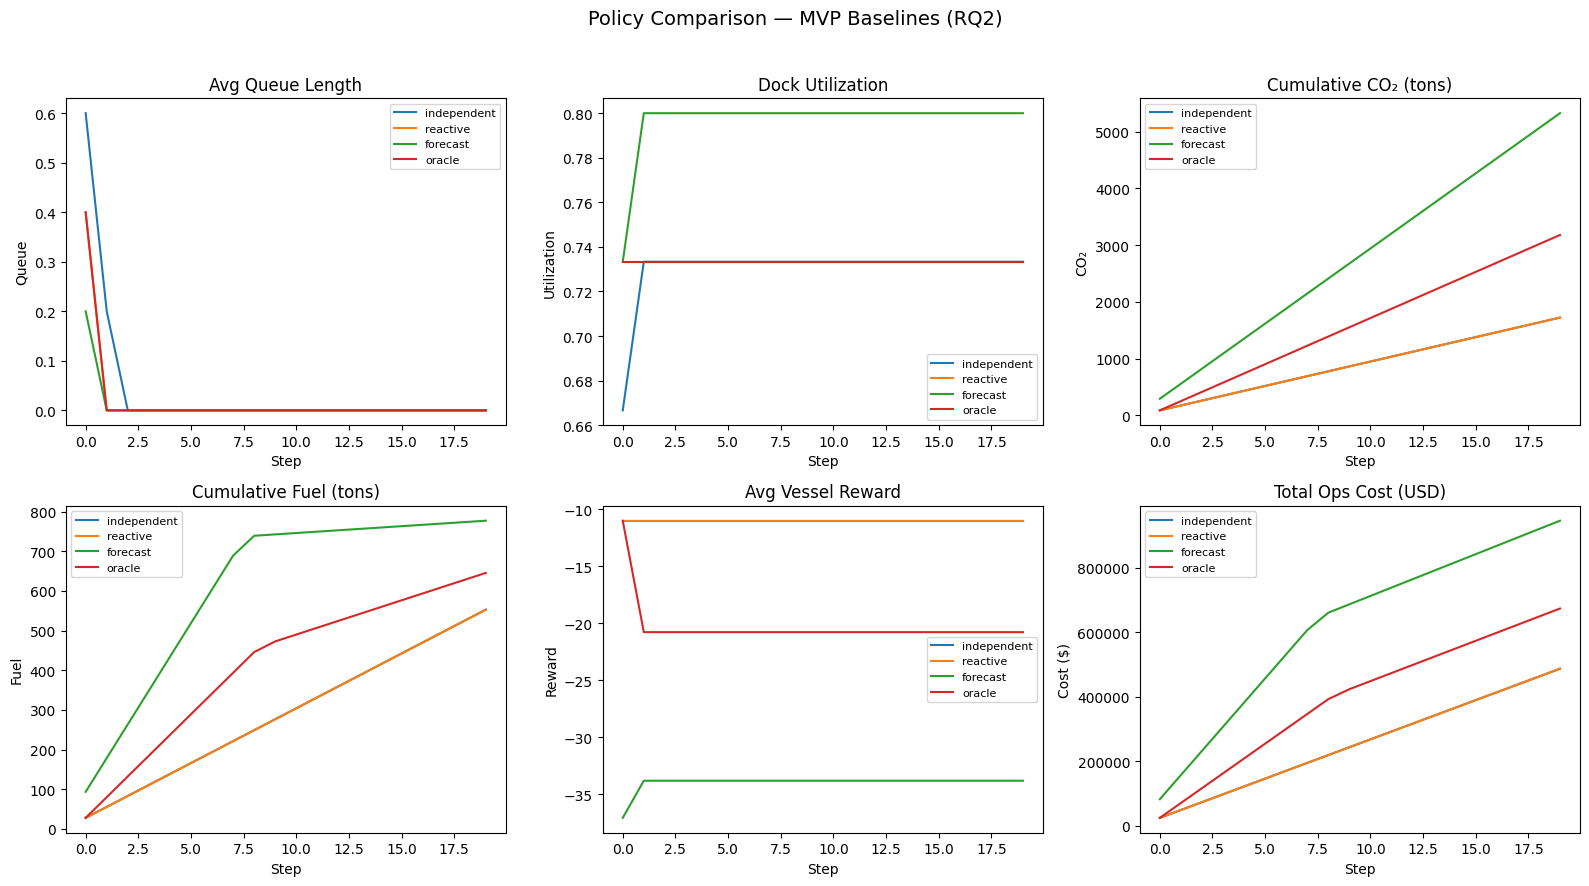

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle("Policy Comparison — MVP Baselines (RQ2)", fontsize=14)

metrics_to_plot = [
    ("avg_queue",           "Avg Queue Length",        "Queue"),
    ("dock_utilization",    "Dock Utilization",        "Utilization"),
    ("total_emissions_co2", "Cumulative CO₂ (tons)",   "CO₂"),
    ("total_fuel_used",     "Cumulative Fuel (tons)",   "Fuel"),
    ("avg_vessel_reward",   "Avg Vessel Reward",        "Reward"),
    ("total_ops_cost_usd",  "Total Ops Cost (USD)",     "Cost ($)"),
]

for ax, (col, title, ylabel) in zip(axes.flat, metrics_to_plot):
    for policy in ["independent", "reactive", "forecast", "oracle"]:
        df = results[policy]
        ax.plot(df["t"], df[col], label=policy)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 10.3 Ablation: forecast horizon sweep (RQ3)
We sweep over different short-term forecast horizons to test which granularity best supports vessel/port decisions.


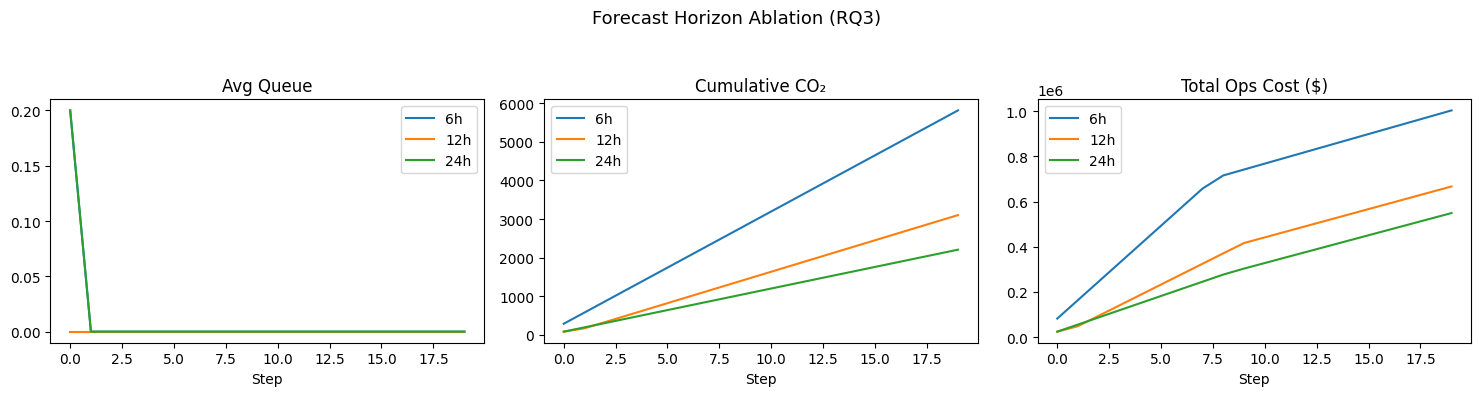

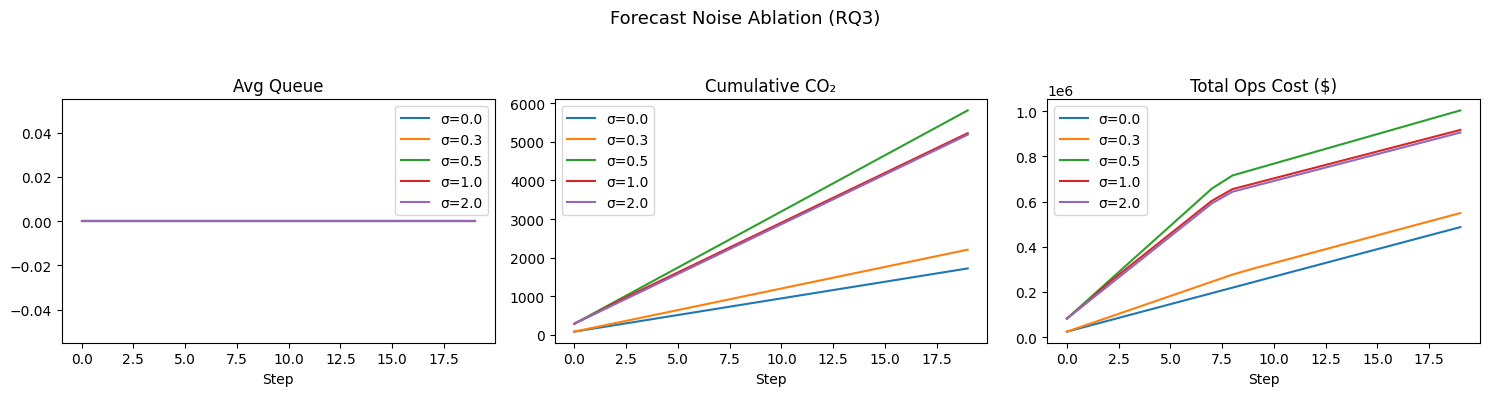

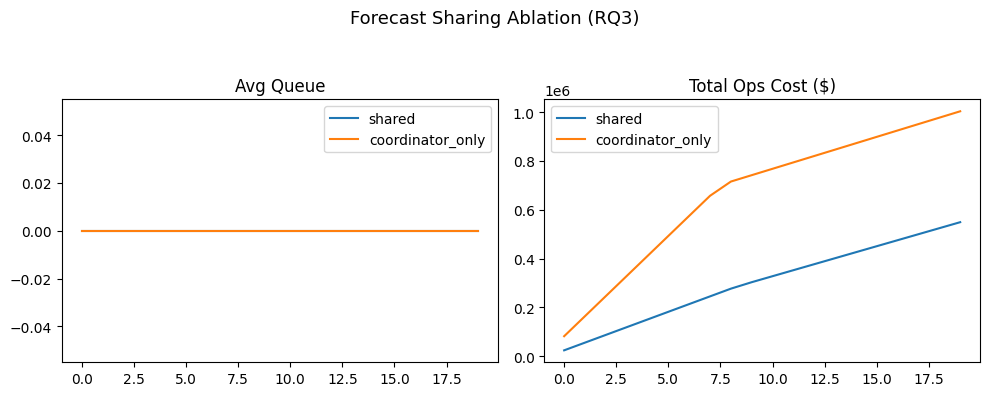

In [14]:
# ---------- Horizon sweep ----------
horizons = [6, 12, 24]
horizon_results = {}
for h in horizons:
    horizon_results[h] = run_experiment(
        policy_type="forecast", forecast_horizon=h, steps=STEPS, seed=SEED
    )

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Forecast Horizon Ablation (RQ3)", fontsize=13)

for ax, (col, title) in zip(axes, [
    ("avg_queue", "Avg Queue"),
    ("total_emissions_co2", "Cumulative CO₂"),
    ("total_ops_cost_usd", "Total Ops Cost ($)"),
]):
    for h in horizons:
        df = horizon_results[h]
        ax.plot(df["t"], df[col], label=f"{h}h")
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# ---------- Noise sweep ----------
noise_levels = [0.0, 0.3, 0.5, 1.0, 2.0]
noise_results = {}
for n in noise_levels:
    noise_results[n] = run_experiment(
        policy_type="forecast", forecast_noise=n, steps=STEPS, seed=SEED
    )

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Forecast Noise Ablation (RQ3)", fontsize=13)

for ax, (col, title) in zip(axes, [
    ("avg_queue", "Avg Queue"),
    ("total_emissions_co2", "Cumulative CO₂"),
    ("total_ops_cost_usd", "Total Ops Cost ($)"),
]):
    for n in noise_levels:
        df = noise_results[n]
        ax.plot(df["t"], df[col], label=f"σ={n}")
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# ---------- Sharing ablation ----------
sharing_configs = {"shared": True, "coordinator_only": False}
sharing_results = {}
for label, share in sharing_configs.items():
    sharing_results[label] = run_experiment(
        policy_type="forecast", share_forecasts=share, steps=STEPS, seed=SEED
    )

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Forecast Sharing Ablation (RQ3)", fontsize=13)
for label in sharing_configs:
    df = sharing_results[label]
    ax[0].plot(df["t"], df["avg_queue"], label=label)
    ax[1].plot(df["t"], df["total_ops_cost_usd"], label=label)
ax[0].set_title("Avg Queue"); ax[0].legend()
ax[1].set_title("Total Ops Cost ($)"); ax[1].legend()
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## 11. MVP-to-Research checklist
This checklist traces what is **covered** in the MVP versus what remains for the research-grade implementation.

| Component | MVP status | Research-grade upgrade |
|-----------|-----------|----------------------|
| Agent hierarchy (coordinator → vessel → port) | ✅ Implemented | Add learned policies via MAPPO |
| Vessel movement & transit model | ✅ Distance matrix + step_vessels | Add weather, routing alternatives |
| Fuel consumption (cubic model) | ✅ Implemented | Calibrate with AIS data |
| CO₂ emissions + budget tracking | ✅ Implemented | Add ECA zones, scrubber effects |
| Per-agent reward functions (R_C, R_V, R_P) | ✅ Implemented | Tune weights via hyperparameter search |
| Gymnasium env skeleton (reset/step) | ✅ Implemented | Swap ABC → gymnasium.Env, add Spaces |
| Centralized critic (CTDE) | ✅ Global state concatenation stub | Wire into MAPPO shared critic |
| Medium + short-term forecasting | ✅ Mock (noisy trends) | Replace with RNN / econometric models |
| Forecast ablations (horizon, noise, sharing) | ✅ Parameterized runner | Run at scale with learned models |
| Baseline comparison (4 policies) | ✅ Independent/reactive/forecast/oracle | Add heuristic baselines |
| Vessel metrics (fuel, delay, on-time rate) | ✅ Implemented | Add per-trip breakdown |
| Port metrics (queue, util, wait time) | ✅ Implemented | Add throughput, turnaround time |
| Coordination metrics (agreement rate) | ✅ Implemented | Add communication overhead |
| Economic metrics (cost, reliability, RQ4) | ✅ Implemented | Calibrate with shipping market data |
| RQ traceability | ✅ Annotated in code and markdown | Formal experiment → RQ mapping |


## 12. Next steps for the full project

### Month 2 (March) — Forecasting & baselines
1. **Replace mock forecasts** with trained models (RNN for short-term, econometric for medium-term).
2. **Validate forecast accuracy** using MAE/RMSE on synthetic + AIS data.
3. **Implement heuristic baselines** (FCFS port scheduling, constant-speed vessels).

### Month 3 (April) — MAPPO training
4. **Swap `MaritimeEnv` base class** to `gymnasium.Env` with proper `observation_space` / `action_space`.
5. **Implement MAPPO** (Multi-Agent PPO) with centralized critic using the `get_global_state()` method.
6. **Train coordinated agents** under reactive and forecast-informed settings.
7. **Debug reward shaping** and inter-agent communication protocols.

### Month 4 (May) — Ablations & evaluation
8. **Run full ablation studies**: horizon sweep, noise sweep, sharing modes, centralized vs decentralized.
9. **Compare all baselines** (independent, reactive, heuristic, forecast, oracle) using the metric suite.
10. **Analyze economic impact** (RQ4): shipping cost variability, price reliability.
11. **Compile results** and prepare the final report and VIP presentation.

This MVP provides a **complete, executable foundation** covering agent hierarchy, physical dynamics, reward functions, metrics, and ablation infrastructure. The transition to research-grade requires swapping stubs for learned components while keeping the same evaluation pipeline.
